<a href="https://www.kaggle.com/code/averma111/ps3e13-map-k-tensorflow?scriptVersionId=126821661" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e13/sample_submission.csv
/kaggle/input/playground-series-s3e13/train.csv
/kaggle/input/playground-series-s3e13/test.csv


## Reading the train data using pandas


In [2]:
ROOT_PATH ='/kaggle/input/playground-series-s3e13'
train = pd.read_csv(ROOT_PATH+'/train.csv')
train.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever


## Check the summary of the train dataset

In [3]:
def dataset_summary(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary['Null'] = df.isnull().sum()
    summary['Unique'] = df.nunique()
    summary['min'] = df.min()
    summary['median'] = df.median()
    summary['max'] = df.max()
    summary['mean'] = df.mean()
    summary['std'] = df.std()
    
    return summary

In [4]:
dataset_summary(train)

,dtypes,Null,Unique,min,median,max,mean,std
id,int64,0,707,0,353.0,706,353.000000,204.237607
sudden_fever,float64,0,2,0.0,1.0,1.0,0.503536,0.500341
headache,float64,0,2,0.0,0.0,1.0,0.449788,0.497825
mouth_bleed,float64,0,2,0.0,0.0,1.0,0.459689,0.498725
nose_bleed,float64,0,2,0.0,0.0,1.0,0.487977,0.500209
...,...,...,...,...,...,...,...,...
ulcers,float64,0,2,0.0,0.0,1.0,0.144272,0.351614
toenail_loss,float64,0,2,0.0,0.0,1.0,0.137199,0.344301
speech_problem,float64,0,2,0.0,0.0,1.0,0.032532,0.177533
bullseye_rash,float64,0,2,0.0,0.0,1.0,0.031117,0.173758


## Observation from summary of train dataset
* There are no null value in any columns
* Apart from Id and prognosis all the columns are categorial
* The categorical datatype is float64

<Figure size 1500x1500 with 0 Axes>

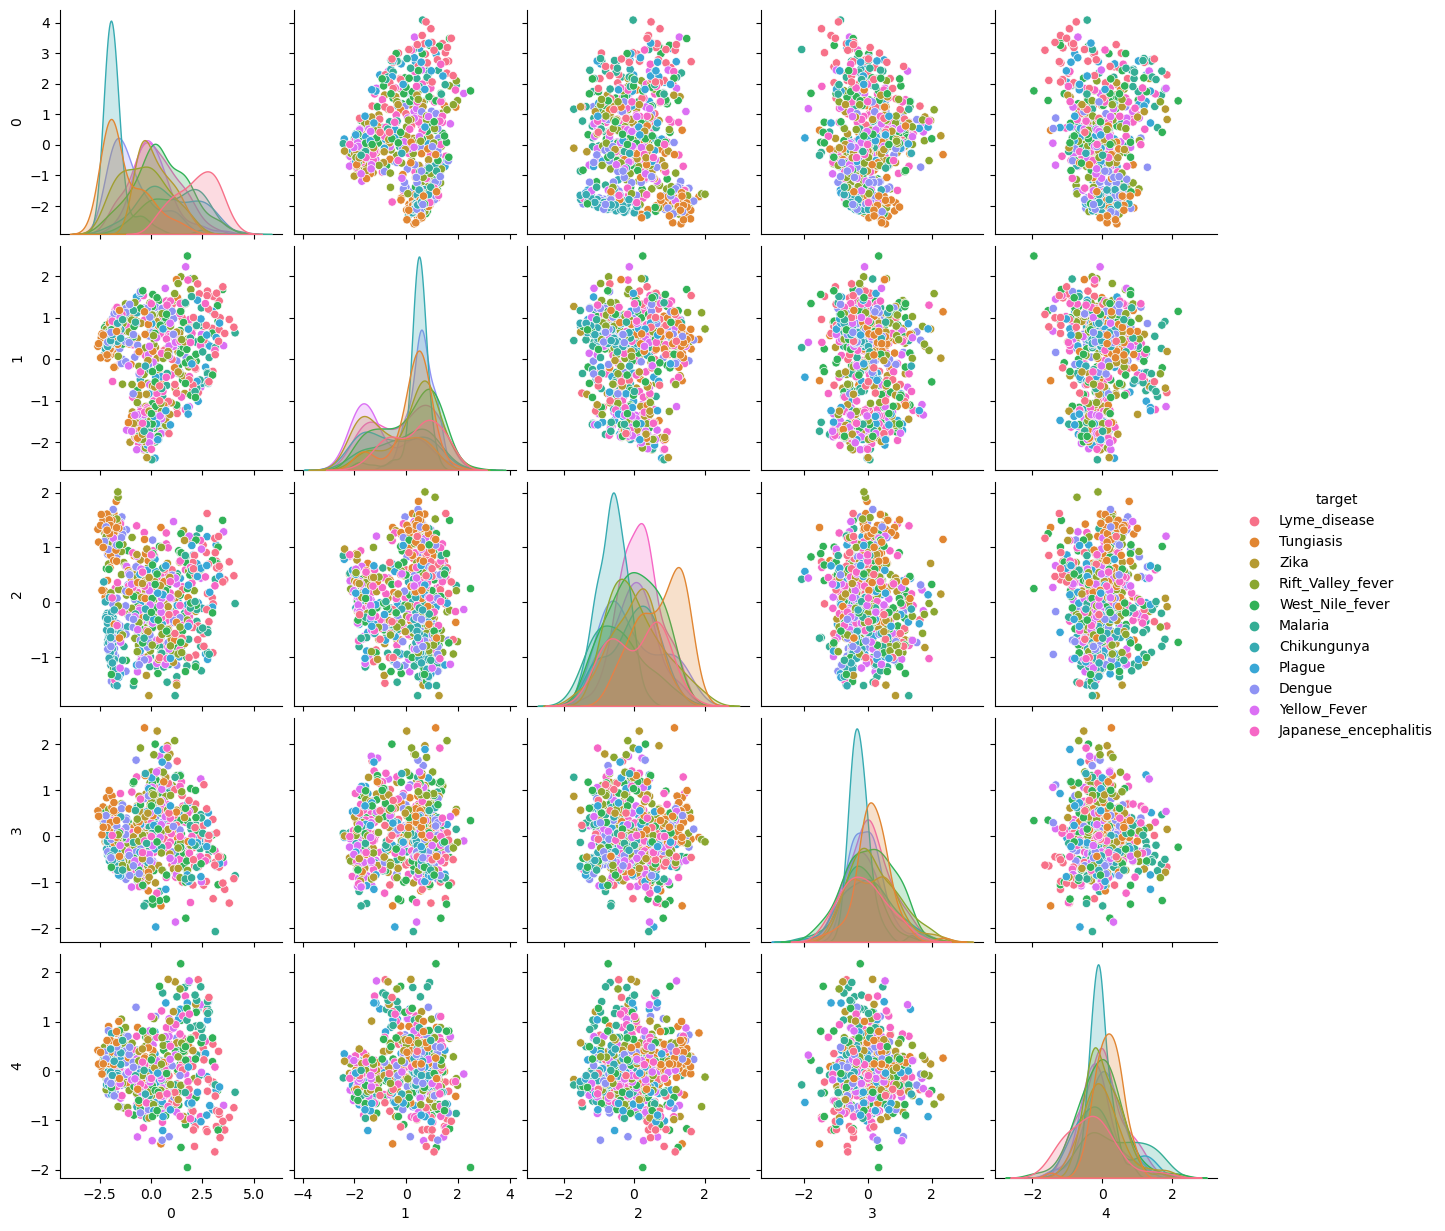

In [22]:
import seaborn as sns
plt.figure(figsize = (15,15))
sns.pairplot(train,hue = 'target')

## Decomposition train dataset

In [5]:
from sklearn.decomposition import PCA
def get_pca(df):
    df = df.drop('id',axis = 1)
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    pca = PCA(n_components = 5, random_state = 42)
    X = pd.DataFrame(pca.fit_transform(X))
    X['target'] = y
    return X

In [6]:
train = get_pca(train)
df = train.copy()

## Encoding the categorical label data and splitting dataset

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras.utils import to_categorical

# Create X and y
X = df.iloc[:,:-1]
y = df[['target']]

enc = OrdinalEncoder()
y = to_categorical(enc.fit_transform(y))
N_CLASSES = len(enc.categories_[0])
                
# Split between train and test dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify = y,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((565, 5), (142, 5), (565, 11), (142, 11))

## Defining the MAP@K function


In [17]:
def mpk(y_test, predicted):
    k = 3
    mpk_score = 0
    for i, y in enumerate(y_test):
        top_k_preds = predicted[i].argsort()[-k:][::-1]
        mpk_score += np.mean([1 if np.argmax(y) in top_k_preds[:j+1] else 0 for j in range(k)])
    mpk_score /= len(y_test)
    return mpk_score

## Basic_Model

In [9]:
def better_model():
    inputs = tf.keras.layers.Input(shape=X_train.shape[1:])
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    for _ in range(3):
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(32,kernel_regularizer = tf.keras.regularizers.l2(0.01),
                         activation='relu')(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        
    outputs = tf.keras.layers.Dense(11, activation = 'relu')(x)
    return tf.keras.Model(inputs,outputs)

## Compiling and model summary

In [10]:
model = better_model()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 0.01),
             metrics=['accuracy'])

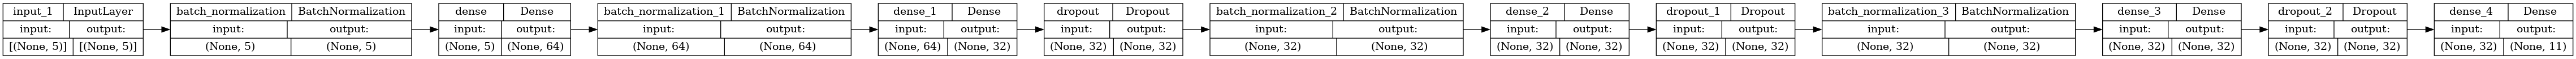

In [11]:
tf.keras.utils.plot_model(model, rankdir='LR',show_shapes=True)

## Fitting the model

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 30)
history = model.fit(X_train,y_train,
                    validation_data = (X_test,y_test),
                    epochs = 9999,
                   callbacks = [early_stopping],verbose=0)

In [13]:
def make_plot(history):
    fig,ax = plt.subplots(ncols = 2, figsize = (15,5))
    ax[0].plot(history.history['loss'], label = 'train_loss', c = 'blue')
    ax[0].plot(history.history['val_loss'], label = 'valid_loss', c = 'green')
    ax[0].legend(loc = 'upper right')
    ax[0].set_title('train,valid loss')
    ax[1].plot(history.history['accuracy'], label = 'train_accuracy', c = 'blue')
    ax[1].plot(history.history['val_accuracy'], label = 'valid_accuracy', c = 'green')
    ax[1].legend(loc = 'lower right')
    ax[1].set_title('train,valid accuracy')

## Plotting the history model data

5/5 [==============================] - 0s 2ms/step


Text(0.5, 0.98, 'MPK :0.385')

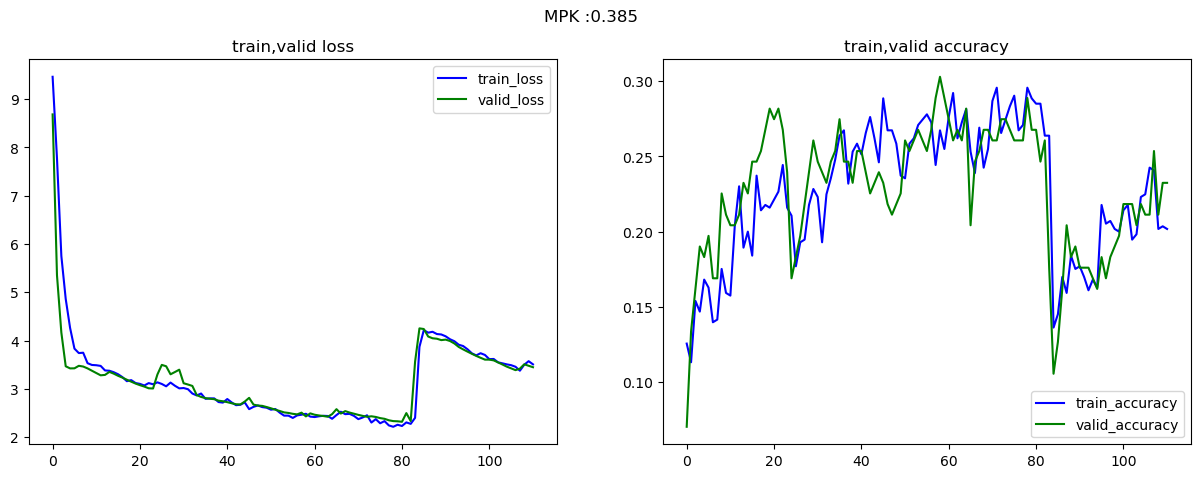

In [20]:
make_plot(history)
plt.suptitle(f'MPK :{mpk(y_test,model.predict(X_test)):.3f}')

## Reading test data 

In [ ]:
test = pd.read_csv(ROOT_PATH+'/test.csv')
plt.figure(figsize = (15,15))
sns.pairplot(test,hue = 'target')

In [25]:
pca = PCA(n_components = 5, random_state = 42)
test = pca.fit_transform(test.drop('id',axis = 1))


TypeError: 'data' must be pandas DataFrame object, not: <class 'numpy.ndarray'>

<Figure size 1500x1500 with 0 Axes>

## Preparing the test data for submission

In [264]:
def submissions(probabilities):
    result = []
    for prob in probabilities:
        result.append(prob.argsort()[-3:][::-1])
    reverse = {}
    for i,cate in enumerate(enc.categories_[0]):
        reverse[i] = cate
    df = pd.DataFrame(result)
    to_submission = df[0].map(reverse) + ' ' + df[1].map(reverse) + ' ' + df[2].map(reverse)
    return to_submission

In [265]:
submission_df = pd.read_csv(ROOT_PATH+'/sample_submission.csv')
submission_df['prognosis'] = submissions(model.predict(test))

10/10 [==============================] - 0s 2ms/step


## Submitting the file

In [266]:
submission_df.to_csv('submission.csv', index = False)